In [2]:
import os
os.chdir('/opt/project')
print(os.getcwd())

import pandas as pd
from torchio import SubjectsDataset

from src.preprocessing import SitkImageProcessor
import os
import torchio as tio
import torch
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
from torchio.visualization import plot_histogram
from tqdm import tqdm

/opt/project


In [3]:
def get_adc_tensor(ID_list, data_path, tio_transforms=None):
    sitk_processor = SitkImageProcessor(data_path, mask_stem='mask',
                                        image_stems=('registered_adc',))

    subject_list = sitk_processor.transform(ID_list)['subjects'].to_list()

    subject_dataset = SubjectsDataset(subject_list, transform=tio_transforms)

    # adc_tensor = torch.concatenate(
    #     [torch.concatenate([torch.flatten(i.data).nonzero() for i in subject.get_images()]) for subject in
    #      subject_dataset])

    adc_tensor = torch.tensor([[torch.mean(torch.flatten(i.data).nonzero().float()) for i in subject.get_images()] for subject in
         tqdm(subject_dataset)])

    return adc_tensor

def get_id_by_grade(data_meta, grade):
    data_meta = pd.read_csv(data_meta)
    # ID_list = data_meta['ID'].to_list()
    id = data_meta['Patient_ID'].loc[(data_meta['Grade'] == grade)].to_list()

    return id

def plot_histogram_by_grade(data_meta, data_path, grade, transforms=None, **kwargs):
    id_list = get_id_by_grade(data_meta, grade)
    adc_tensor = get_adc_tensor(id_list, data_path, tio_transforms=transforms)

    # hist = ndi.histogram(adc_tensor, min=0, max=max_histo, bins=bins)
    # plt.plot(hist)
    plot_histogram(adc_tensor.numpy(), show=False, **kwargs)

    return plt.gcf()

def get_mean_by_grade(data_meta, data_path, grade, transforms=None):
    id_list = get_id_by_grade(data_meta, grade)
    adc_tensor = get_adc_tensor(id_list, data_path, tio_transforms=transforms)

    return torch.mean(adc_tensor), torch.std(adc_tensor)

In [4]:
data_path = './data/meningioma_data'
data_meta = './data/meningioma_meta.csv'

transforms = tio.Compose([tio.Resample((1, 1, 1)),
                          tio.CropOrPad(mask_name='mask'),
                          tio.ToCanonical(),
                          tio.Mask(masking_method='mask', outside_value=0),
                          tio.ZNormalization(masking_method='mask')
                          ])

100% 18/18 [00:25<00:00,  1.42s/it]
100% 97/97 [01:57<00:00,  1.21s/it]


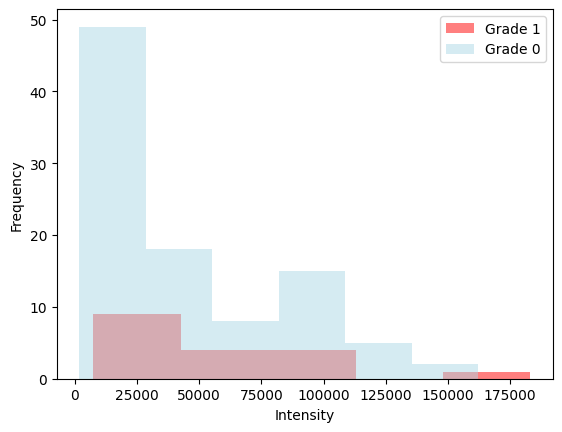

In [5]:
plot_histogram_by_grade(data_meta,
                        data_path=data_path,
                        grade=1,
                        transforms=transforms,
                        alpha=0.5,
                        color='red',
                        label='Grade 1',
                        density=False
                        )

plot_histogram_by_grade(data_meta,
                        data_path=data_path,
                        grade=0,
                        transforms=transforms,
                        alpha=0.5,
                        color='lightblue',
                        label='Grade 0',
                        density=False
                        )
plt.legend()
plt.show()

In [7]:
mean, std = get_mean_by_grade(data_meta,
                        data_path=data_path,
                        grade=1,
                        transforms=transforms)
print(f"Grade 1 mean {mean}, std: {std}")

mean, std = get_mean_by_grade(data_meta,
                        data_path=data_path,
                        grade=0,
                        transforms=transforms)
print(f"Grade 0 mean {mean}, std: {std}")

100% 18/18 [00:19<00:00,  1.09s/it]


Grade 1 mean 55859.8046875, std: 42191.26171875


100% 97/97 [01:42<00:00,  1.06s/it]

Grade 0 mean 43051.47265625, std: 40536.21484375
